# Building NeutralScore, a classification Model for non-toxic versus toxic detection.

We'll build a classification model using Kaggle Jigsaw Toxic Classification dataset to classify if a post is non-toxic or toxic. The result of this classification model will be used as an evaluating metric for our Style Transfer model. 

## 1. Set up

In [5]:
!pip install -q transformers

In [6]:
#Am I running a GPU and what type is it?
!nvidia-smi

Sun Mar 12 00:36:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = torch.device("cpu")

Number of GPU(s) available: 1
GPU device name: Tesla T4


In [8]:
from logging import warning
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import BertTokenizer, BertModel

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime


import warnings
warnings.filterwarnings('ignore')


In [9]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
cd drive/MyDrive/w266/style_transfer_w266/

/content/drive/MyDrive/w266/style_transfer_w266


## 2.EDA & Data Preprocessing

We could see that the jigsaw data split the toxic comments into different categories. For our model, we will include all of these categories into a toxic category:
 - toxic
 - severe_toxic
 - obscene
 - threat
 - insult
 - identity_hate

 Our model goal is to classify if a post is non-toxic (label = 1) versus toxic (label = 0), which could be used as a NonToxicScore metric.

In [12]:
text_file = 'data/jigsaw_classification_data.csv'
df = pd.read_csv(text_file)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
# EDA
print('Count of toxic:')
print(df.toxic.value_counts())

print('\nCount of severe toxic:')
print(df.severe_toxic.value_counts())

print('\nCount of obscene:')
print(df.obscene.value_counts())

print('\nCount of threat:')
print(df.threat.value_counts())

print('\nCount of insult:')
print(df.insult.value_counts())

print('\nCount of identity hate:')
print(df.identity_hate.value_counts())

Count of toxic:
0    144277
1     15294
Name: toxic, dtype: int64

Count of severe toxic:
0    157976
1      1595
Name: severe_toxic, dtype: int64

Count of obscene:
0    151122
1      8449
Name: obscene, dtype: int64

Count of threat:
0    159093
1       478
Name: threat, dtype: int64

Count of insult:
0    151694
1      7877
Name: insult, dtype: int64

Count of identity hate:
0    158166
1      1405
Name: identity_hate, dtype: int64


In [14]:
# Create a label column with 0 = toxic, 1 = non-toxic
df['label'] = (df.toxic + df.severe_toxic + df.obscene + df.threat + df.insult + df.identity_hate) == 0
df['label'] = df['label'].astype(int)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [15]:
# Count toxic & non-toxic labels 
print('\nCount of non_toxic labels:')
print(df.label.value_counts())


Count of non_toxic labels:
1    143346
0     16225
Name: label, dtype: int64


In [16]:
def modify_text_to_print(df_original, column="comment_text"):
  """Modify some toxic, offensive texts in the dataframe for printing out"""
  df = df_original.copy()
  df[column] = df[column].apply(lambda x: x.lower().replace('fuck', 'f***')\
                              .replace('shit', 's***')\
                              .replace('rape', 'r***')\
                              .replace('dick', 'd***'))

  return df

In [17]:
## Perform under_sampling to create balance the dataset
# Change majority class (non-toxic) to minority ~70%
# Change minority class (toxic) to majority ~30%
# Separate majority and minority classes
df_majority = df[df["label"] == 1]
df_minority = df[df["label"] == 0]

# Undersample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,     # sample without replacement
                                   n_samples=round(len(df_minority)*0.6),    # change majority to minority clas
                                   random_state=42) 

# Combine minority class and downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the rows
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Count toxic & non-toxic labels for downsampled dataframe
print('\nCount of non_toxic labels:')
print(df_downsampled.label.value_counts())

modify_text_to_print(df_downsampled).head()


Count of non_toxic labels:
0    16225
1     9735
Name: label, dtype: int64


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
0,8d29127a568fa715,you are a notorious troll and vandal too hrafn.,1,0,0,0,0,0,0
1,4d5cdc10fd9c03b9,"""\n\n please do not vandalize pages, as you di...",0,0,0,0,0,0,1
2,097b9d1ce20a0298,i made clear trabzon as turkish name of the ci...,0,0,0,0,0,0,1
3,27a4e4afe9c5f9db,to make it stand out,0,0,0,0,0,0,1
4,02f77830b4d71c0f,whoever put a notices on my page. i will kill u,1,0,0,1,0,0,0


In [18]:
## Data Clean Up
def clean_up_text(x):
  """Remove line breaks, special characters, punctuations within each post"""
  # Remove special characters and punctuations
  SPECIAL_CHARS_PATTERN = re.compile(r"(\*)|(\=\=)|(\~)|(\=)|(\.\.\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
  x = SPECIAL_CHARS_PATTERN.sub("", x.lower())

  # Remove different types of line breaks and white spaces
  x = re.sub(r"\n|\r|\r\n|<br\s*/?>", " ", x)
  
  # Remove extra white spaces
  x = re.sub(r"\s+", " ", x.strip())

  return x

df_downsampled["cleaned_text"] = df_downsampled.comment_text.apply(clean_up_text)
modify_text_to_print(df_downsampled[["cleaned_text", "label"]],"cleaned_text").head()

,cleaned_text,label
0,you are a notorious troll and vandal too hrafn.,0
1,please do not vandalize pages as you did with ...,1
2,i made clear trabzon as turkish name of the ci...,1
3,to make it stand out,1
4,whoever put a notices on my page. i will kill u,0


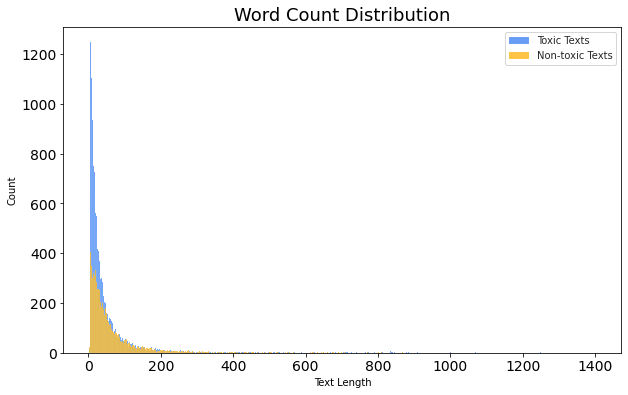

In [19]:
# Calculate word counts
df_downsampled['word_count'] = df_downsampled['cleaned_text'].apply(lambda x: len(x.split(' ')))
df_toxic = df_downsampled[df_downsampled.label == 0]
df_nontoxic = df_downsampled[df_downsampled.label == 1]

### Plot the word-count distribution for the toxic texts and the non toxic texts.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')

# calculate the bin size based on the range of the data
bins = range(min(df_toxic['word_count'].min(), df_nontoxic['word_count'].min()), 
             max(df_toxic['word_count'].max(), df_nontoxic['word_count'].max()) + 2, 2)

# plot the histograms with the same bin size
sns.histplot(data=df_toxic, x='word_count', label='Toxic Texts', bins=bins, color='#4285F4', alpha=0.8)
sns.histplot(data=df_nontoxic, x='word_count', label='Non-toxic Texts', bins=bins, color='#FDB515', alpha=0.8)

# set the axis labels and title
ax.set(xlabel='Text Length', ylabel='Count')
ax.set_title('Word Count Distribution', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)
plt.legend(loc='upper right')

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)


In [20]:
## Train, Val, Test Split
X_full =  df_downsampled["cleaned_text"]
y_full = df_downsampled["label"]

# Split test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X_full, y_full, 
                                                            test_size=0.12,
                                                            random_state=42,
                                                            stratify=y_full
                                                            )

# Split train - dev
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size=0.15,
                                                            random_state=42,
                                                            stratify=y_train_val
                                                            )

print('Train Data Dimension:', X_train.shape)
print('Train Label Dimension:', y_train.shape)
print('Development Data Dimension:', X_val.shape)
print('Development Label Dimension:', y_val.shape)
print('Test Data Dimension:', X_test.shape)
print('Test Label Dimension:', y_test.shape)

Train Data Dimension: (19417,)
Train Label Dimension: (19417,)
Development Data Dimension: (3427,)
Development Label Dimension: (3427,)
Test Data Dimension: (3116,)
Test Label Dimension: (3116,)


### 3. Classification Model with BERT

In [21]:
# Clear out cuda before training
torch.cuda.empty_cache()

In [22]:
# Load the BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# From the word count distribution, most posts from the pair-wise detoxify dataset  are within 32.
max_length = 64

train_encodings = bert_tokenizer(
    list(X_train.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

valid_encodings = bert_tokenizer(
    list(X_val.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

test_encodings = bert_tokenizer(
    list(X_test.values), 
    max_length=max_length,
    truncation=True,
    pad_to_max_length=True, 
    return_tensors='pt'
)

train_encodings

{'input_ids': tensor([[  101, 11865,  6616,  ...,     0,     0,     0],
        [  101,  1012,  1996,  ...,     0,     0,     0],
        [  101, 16350,  4007,  ...,  2202,  2070,   102],
        ...,
        [  101, 22052,  8444,  ...,     0,     0,     0],
        [  101,  2043,  2106,  ...,     0,     0,     0],
        [  101,  8991,  1060,  ...,  2035,  2026,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [23]:
## HYPER-PARAMETERS BLOCKS
BATCH_SIZE = 16
LR =2e-5
WEIGHT_DECAY = 5e-4
EPOCHS = 4
HIDDEN_SIZE = 768
DROP_OUT = 0.1
WORKERS = int(os.cpu_count())

In [24]:
## Data Loader
train_ids = train_encodings.input_ids
train_mask = train_encodings.attention_mask
train_token_type_ids = train_encodings.token_type_ids
train_labels = torch.tensor(y_train.values) 

val_ids = valid_encodings.input_ids
val_mask = valid_encodings.attention_mask
val_token_type_ids = valid_encodings.token_type_ids
val_labels = torch.tensor(y_val.values)

test_ids = test_encodings.input_ids
test_mask = test_encodings.attention_mask
test_token_type_ids = test_encodings.token_type_ids
test_labels = torch.tensor(y_test.values)

train_dataset = TensorDataset(train_ids, train_mask, train_token_type_ids, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

val_dataset = TensorDataset(val_ids, val_mask, val_token_type_ids, val_labels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

test_dataset = TensorDataset(test_ids, test_mask, test_token_type_ids, test_labels)
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)


In [25]:
# BERT Model
class BertClassification(nn.Module):
    def __init__(self,output_dim=1, hidden_size=768, dropout=0.1):
        super(BertClassification, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')

        self.bert_hidden_size = self.bert_model.config.hidden_size
        self.hidden_size = hidden_size
        self.hidden_layer = nn.Linear(self.bert_hidden_size, self.hidden_size)

        self.drop_out = nn.Dropout(dropout)

        self.classification = nn.Linear(self.hidden_size, output_dim)

        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert_model(input_ids=input_ids, 
                                      attention_mask=attention_mask, 
                                      token_type_ids=token_type_ids)
        
        # hidden_state = bert_output[0]
        cls_token = bert_output[0][:,0]

        hidden_ouput = self.ReLU(self.hidden_layer(cls_token))
        
        hidden_ouput = self.drop_out(hidden_ouput)
        output = self.Sigmoid(self.classification(hidden_ouput))
        output = output.flatten()

        return output

In [26]:
# Initialize model
model = BertClassification(hidden_size=HIDDEN_SIZE, dropout=DROP_OUT)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# Initiate loss to Binary Cross Entropy
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Create learning rate scheduler.
T_max = EPOCHS*len(train_loader)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

In [28]:
def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

In [29]:
## Define train function
def train(train_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, verbose=True):  
    # reset total loss for each epoch
    total_loss = 0

    # switch model to train mode
    model.train()

    # start time
    t0 = time.time()

    for step, data in enumerate(train_loader):
    
        # send the data to cuda device
        ids = data[0].to(device, dtype = torch.long)
        mask = data[1].to(device, dtype = torch.long)
        token_type_ids = data[2].to(device, dtype = torch.long)
        target = data[3].float().to(device)
    
        # compute output
        output = model(input_ids=ids, 
                      attention_mask=mask, 
                      token_type_ids=token_type_ids)

        # compute loss 
        loss = criterion(output, target)

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()

        # zero out gradients in the optimizer each step
        optimizer.zero_grad()

        # Report progress every 40 batches
        if step % 100 == 0 and not step == 0 and verbose==True:
            print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                 step, 
                 len(train_loader),
                 loss.item(),
                 format_time(time.time() - t0))) 
        
        # compute gradient and do SGD
        # backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # update learning rate
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader) 
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Training Loss {:0.4f}, Completed in {:} \n".format(
          avg_train_loss,
          format_time(elapsed_time)
            ))
    
    # return model, avg_train_loss, elapsed_time
    return avg_train_loss, elapsed_time
 

In [30]:
## Define validate function
def validate(val_loader=val_loader, model=model, criterion=criterion, verbose=True):
    # Initialize
    targets=[]
    outputs=[]
    t0 = time.time()
    total_val_loss = 0

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        # end = time.time()
        for step, data in enumerate(val_loader):
            
            # send the data to cuda device
            ids = data[0].to(device, dtype = torch.long)
            mask = data[1].to(device, dtype = torch.long)
            token_type_ids = data[2].to(device, dtype = torch.long)
            target = data[3].float().to(device)

            # compute output
            output = model(input_ids=ids,
                           attention_mask=mask,
                           token_type_ids=token_type_ids)

            # compute loss
            loss = criterion(output, target)

            # Accumulate the validation loss over all of the batches to calculate average loss
            total_val_loss += loss.item()

            targets.extend(target.cpu().detach().numpy().tolist())
            outputs.extend(output.cpu().detach().numpy().tolist())

            if step % 100 == 0 and not step == 0 and verbose==True:
                print('Batch {:>5,}  of  {:>5,}.  Loss {:0.4f}  Elapsed: {:}.'.format(
                    step, 
                    len(val_loader),
                    loss.item(),
                    format_time(time.time() - t0)))        

    avg_val_loss = total_val_loss / len(val_loader)
    elapsed_time = time.time() - t0
    if verbose:
      print ("\nAvg Validation Loss {:0.4f}, Completed in {:}".format(
          avg_val_loss,
          format_time(elapsed_time)
            ))
    
    return outputs, targets, avg_val_loss, elapsed_time


In [31]:
# calculate the F1 score, auc, accuracy of our predictions vs labels
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

def compute_metrics(outputs, targets):
    y_pred = (np.array(outputs) >= 0.5).astype(float)
    y_true = np.array(targets)

    # metrics
    f1 = f1_score(y_true= y_true, y_pred=y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    # accuracy = np.sum(y_pred == y_true) / len(y_true)

    print ("F1 Score {:0.4f}, ROC AUC {:0.4f}, Accuracy {:0.4f} \n".format(f1, roc_auc, accuracy))

    return f1, roc_auc, accuracy

In [32]:
# Store the average loss after each epoch so we can plot them.
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCHS):
    print ('######  Epoch {}/{} ######'.format(epoch+1, EPOCHS))
    print ('-----  Training -----')
    train_loss, train_time = train(train_loader, model, criterion, optimizer)
    train_loss_values.append(train_loss)

    print ('-----  Validation -----')
    val_outputs, val_targets, val_loss, val_time = validate(val_loader, model, criterion)
    val_loss_values.append(val_loss)
    val_f1, val_roc_auc, val_accuracy = compute_metrics(val_outputs, val_targets)


######  Epoch 1/4 ######
-----  Training -----
Batch   100  of  1,214.  Loss 0.1811  Elapsed: 0:00:22.
Batch   200  of  1,214.  Loss 0.0497  Elapsed: 0:00:41.
Batch   300  of  1,214.  Loss 0.2723  Elapsed: 0:00:59.
Batch   400  of  1,214.  Loss 0.0996  Elapsed: 0:01:20.
Batch   500  of  1,214.  Loss 0.1417  Elapsed: 0:01:39.
Batch   600  of  1,214.  Loss 0.3655  Elapsed: 0:01:58.
Batch   700  of  1,214.  Loss 0.0694  Elapsed: 0:02:17.
Batch   800  of  1,214.  Loss 0.2834  Elapsed: 0:02:37.
Batch   900  of  1,214.  Loss 0.1729  Elapsed: 0:02:56.
Batch 1,000  of  1,214.  Loss 0.0953  Elapsed: 0:03:15.
Batch 1,100  of  1,214.  Loss 0.1511  Elapsed: 0:03:35.
Batch 1,200  of  1,214.  Loss 0.1756  Elapsed: 0:03:55.

Avg Training Loss 0.2133, Completed in 0:03:57 

-----  Validation -----
Batch   100  of    215.  Loss 0.0513  Elapsed: 0:00:06.
Batch   200  of    215.  Loss 0.2034  Elapsed: 0:00:12.

Avg Validation Loss 0.1786, Completed in 0:00:13
F1 Score 0.9010, ROC AUC 0.9177, Accuracy 0.9

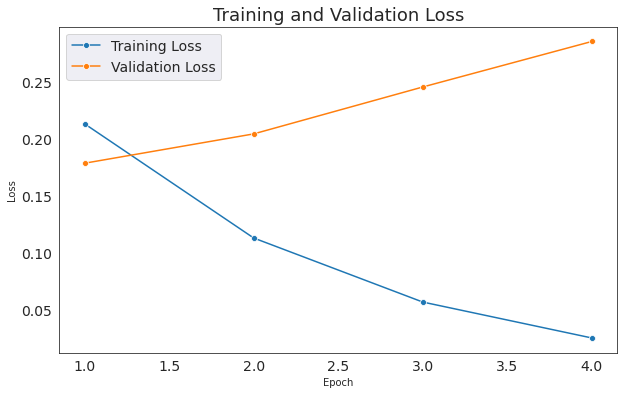

In [33]:
### Plot Training & Validation Loss
data = {'Epoch': range(1, 5), 'Training Loss': train_loss_values, 'Validation Loss': val_loss_values}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.grid(True, which='both', linestyle='--', color='lightgray')

In [34]:
# Predicting with Test Set
test_outputs, test_targets, test_loss, test_time = validate(test_loader, model, criterion, verbose=False)
print('\nEvaluation metrics for Test Set:')
test_f1, test_roc_auc, test_accuracy = compute_metrics(test_outputs, test_targets)


Evaluation metrics for Test Set:
F1 Score 0.9077, ROC AUC 0.9251, Accuracy 0.9314 



In [36]:
torch.save(model.state_dict(), 'models/BertToxicClassification1.pth')